# Energy Modelling - Main Program in Jupyter Notebook

#### Project: MIRACA
#### License: MIT License
#### Copyright (c) 2024 miracaEU Contributors
#### See LICENSE file for details.

## Import Modules

In [2]:
import os
# If needed DLL Directory uncomment below line 
#os.add_dll_directory(os.path.join(os.environ['CONDA_PREFIX'], 'Library', 'bin'))
import shapely
import openpyxl
import xlrd
import pandapower as pp
import pandas as pd
import sys

sys.path.append('./scripts')
from __prompt_for_countries import prompt_for_valid_countries, get_country_code, transform_iso_code
from _0_filter_network import filter_network_by_countries, connect_DC_elements
from _1_load_processing import process_and_save_profiles
from _2_gis_processing import process_regions
from pandapower.plotting import pf_res_plotly, simple_plotly
from _3_electricity_demand import distribute_load_to_nuts
from _3_2_get_fuel_price import get_fuel_price, get_co2_prices
from _3_3_marginal_costs import load_costs, process_powerplants_data
from shapely.geometry import Point
from _4_mapping_gen_and_load import create_gen_or_load
from _5_check_connections import check_connections, verify_slack_connection
from _7_time_series_and_pf_calculations import (
    time_series_pf_results,
    adjust_hvdc_link_capacity,
    time_series_pf_results_separate_exports,
)
from _8_1_plot_NUTS_regions_and_connections import (
    plot_regions,
    plot_bus_nuts_connections,
    plot_bus_gen_connections,
)
from _8_2_plot_generation_and_consumption import plot_power_flow_with_lines


Available EU countries: ['Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'Kosovo', 'Moldova']



## Prompt for countries   

In [3]:
# Main script logic
if __name__ == "__main__":
    countries_to_filter_full, countries_to_filter = prompt_for_valid_countries()
    countries_to_filter_iso = get_country_code(countries_to_filter, iso=True)
    countries_to_filter = [transform_iso_code(code) for code in countries_to_filter_iso]
    print()
    print(" Countries to filter:", countries_to_filter)
    print()
    print(" Countries to filter (ISO codes):", countries_to_filter_iso)
    
start_time = "2015-01-01 00:00:00"
end_time = "2016-01-01 01:00:00"

Enter country or countries (e.g., 'Slovenia, Austria' or 'SI, AT'). You can use full names or country codes. Type 'all' or 'EU' to process all available options:  SI



 Countries to filter: ['SI']

 Countries to filter (ISO codes): ['SI']


## Import Pandapower Network Structure

In [4]:
net = pp.create_empty_network()

# Define the folder path
folder = "Data\\Net_structure_data"

# Import each DataFrame from CSV files using the correct folder path
net.bus = pd.read_csv(os.path.join(folder, "bus_data.csv"))
net.bus_geodata = pd.read_csv(os.path.join(folder, "bus_geodata.csv"))
net.trafo = pd.read_csv(os.path.join(folder, "trafo_data.csv"))
net.line = pd.read_csv(os.path.join(folder, "line_data.csv"))
net.line_geodata = pd.read_csv(os.path.join(folder, "line_geodata.csv"))
print()
print("Import completed!")
print()
net.line.drop(columns=["std_type"], inplace=True)
net.trafo.drop(columns=["std_type"], inplace=True)
net.line.drop(columns=["type"], inplace=True)

# Filter only specific country/countries
from _0_filter_network import filter_network_by_countries, connect_DC_elements

# Filter the network for the specified countries
net = filter_network_by_countries(net, countries_to_filter_iso)
print()
print("Filtered network successfully!")
print()


Import completed!


Filtered network successfully!



## 1 Importing processing data (load profile) 

In [5]:
# Load the dataset
data = pd.read_csv(os.path.join(os.getcwd(), 'Data\\time_series_60min_singleindex.csv'), index_col=0, parse_dates=[0], date_format="%Y-%m-%dT%H:%M:%SZ")

# Get the first and last utc_timestamp from the index
first_timestamp = data.index[0]  # First value in the index
last_timestamp = data.index[-1]  # Last value in the index

print()
print("First UTC Timestamp:", first_timestamp)
print("Last UTC Timestamp:", last_timestamp)
print()

# Define default start and end times
default_start_time = "2015-01-01 00:00:00"
default_end_time = "2015-02-01 01:00:00"

# Prompt the user for start and end times, using defaults if input is empty
start_time = input(f"Enter the start time (default: '{default_start_time}'): ") or default_start_time
end_time = input(f"Enter the end time (default: '{default_end_time}'): ") or default_end_time
print()
# Print the selected times
print("Start time:", start_time)
print("End time:", end_time)
print() 
load_profiles = process_and_save_profiles(data, countries_to_filter_iso, start_time=start_time, end_time=end_time)


First UTC Timestamp: 2014-12-31 23:00:00
Last UTC Timestamp: 2020-09-30 23:00:00



Enter the start time (default: '2015-01-01 00:00:00'):  
Enter the end time (default: '2015-02-01 01:00:00'):  



Start time: 2015-01-01 00:00:00
End time: 2015-02-01 01:00:00



## 2  Importing NUTS3 Data - Proccesing Regions 

In [6]:
# Call the function for 2019 data
processed_regions = process_regions(
    nuts_path=os.path.join(os.getcwd(), 'Data\\NUTS_RG_01M_2024_4326.shp'),
    uk_path=os.path.join(os.getcwd(), 'Data\\UK_NUTS_2021.gpkg'),
    gdp_data_path=os.path.join(os.getcwd(),'Data\\estat_nama_10r_3gdp$defaultview_filtered_en.csv'),
    pop_data_path=os.path.join(os.getcwd(),'Data\\estat_nama_10r_3popgdp$defaultview_filtered_en.csv'),
    country_list=countries_to_filter,
    period=2019,
    nuts_level="NUTS3"
)

## 3 Households and Industrial Demand

In [7]:
# Call the function
distributed_load = distribute_load_to_nuts(
    load_df=load_profiles,
    regions=processed_regions,
    distribution_key={"gdp": 0.6, "pop": 0.4}
)

In [8]:
print(distributed_load[0:2])

         id  LEVL_CODE country       name  NUTS_NAME  MOUNT_TYPE  URBN_TYPE  \
1318  SI031        3.0      SI   Pomurska   Pomurska         NaN        3.0   
1319  SI032        3.0      SI  Podravska  Podravska         NaN        3.0   

      COAST_TYPE                                           geometry level1  \
1318         NaN  POLYGON ((16.24176 46.87629, 16.26450 46.87200...    SI0   
1319         NaN  POLYGON ((15.78642 46.70747, 15.79946 46.69724...    SI0   

     level2 level3      gdp     pop  load_factor  load  
1318   SI03  SI031  15700.0  114.38     0.061250   0.0  
1319   SI03  SI032  18700.0  324.83     0.109065   0.0  


### 3.1 Retrieve and build monthly prices

In [9]:
# Retrieves monthly fuel prices
fuel_price = get_fuel_price("Data\\fuel_prices.xlsx")

### 3.2 Adding Costs

In [10]:
# Costs from: https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2020.csv 
costs = pd.read_csv(os.path.join(os.getcwd(), 'Data\\costs_2020.csv'))

path = os.path.join(os.getcwd(), 'Data\\costs_2020.csv')
costs = load_costs(path, 1) 

### 3.3 Dynamic prices (fuel, co2)

In [11]:
start_interval = pd.to_datetime(start_time)
end_interval = pd.to_datetime(end_time)

# Filter fuel prices within start and end time
filtered_prices = fuel_price.loc[(fuel_price.index >= start_interval) & (fuel_price.index <= end_interval)]

# Check if we have more than two rows
if len(filtered_prices) > 2:
    filtered_prices = filtered_prices.iloc[:-1]  # Exclude the last row
    monthly_fuel_price = filtered_prices.mean().to_frame().T  # Converts mean result into a row format
else:
    monthly_fuel_price = filtered_prices.iloc[[0]]   # If two or fewer rows, take the first row

path = os.path.join(os.getcwd(), 'Data\\powerplants.csv')
plants = process_powerplants_data(path, costs, monthly_fuel_price)

data_folder = os.path.join('Data\\emission-spot-primary-market-auction-report-2012-2024-data')
co2_prices = get_co2_prices(data_folder, start_interval, end_interval)

co2_prices.index = pd.to_datetime(co2_prices.index)

# Calculate the monthly average price
monthly_co2_prices = co2_prices.resample("ME").mean()

plants["adjusted_marginal_price"] = plants["CO2 intensity"] * monthly_co2_prices.iloc[0] + plants["marginal_cost"]

2015


## 4 Mapping Locations of Supply and Demand

In [12]:
plants["country_code"] = plants["country"].apply(get_country_code)
plants = plants[plants['country_code'].isin(countries_to_filter)]
# Create a 'geometry' column from lat and lon data
plants['geometry'] = plants.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
# Add a new column 'zone' by applying the get_country_code() function to the 'country' column
plants["zone"] = plants["country"].apply(lambda x: get_country_code(x, True))

print()
user_input_gen = input("Do you want to distribute plants to their closest bus (without voltage optimization)? (yes/no): ").strip().lower()
print()

distribute_gen = True if user_input_gen in ["yes", "true"] else False

if distribute_gen:
    print("Plants will be distributed to the closest bus without voltage optimization.")
else:
    print("Using voltage optimization and real substations for generator mapping.")

print()
user_input_load = input("Do you want to distribute loads evenly within NUTS regions (without voltage optimization)? (yes/no): ").strip().lower()
print()

distribute_load = True if user_input_load in ["yes", "true"] else False

if distribute_load:
    print("Consumers will be distributed between the NUTS regions without voltage optimization.")
else:
    print("Using voltage optimization and closest real substations for load mapping.")

Do you want to distribute plants to their closest bus (without voltage optimization)? (yes/no):  yes



Plants will be distributed to the closest bus without voltage optimization.



Do you want to distribute loads evenly within NUTS regions (without voltage optimization)? (yes/no):  yes



Consumers will be distributed between the NUTS regions without voltage optimization.


### 4.1 Mapping powerplants

In [13]:
# Call function to create gen
create_gen_or_load(gdf=plants, Type="gen", net=net, distribute_gen=distribute_gen)

power_sum = net.gen["p_mw"].sum()
load_bus_len = len(net.bus)-len(net.gen)
power_per_load = power_sum/load_bus_len
print()
print("Total power of generators: ", power_sum, " MW", "(",power_sum/1000, " GW)")
print()


Total power of generators:  3844.7673661369117  MW ( 3.844767366136912  GW)



### 4.2 Mapping Loads Based on NUTS 3 Regions - p.u.

In [14]:
loads_NUTS3 = distributed_load
loads_NUTS3["zone"] = loads_NUTS3["country"].apply(lambda x: get_country_code(x, True))

# Call function to create loads based on NUTS-3 regions
create_gen_or_load(gdf=loads_NUTS3, Type="load", net=net, distribute_load=distribute_load)

##  5 Assign Slack Bus and Check Connections

In [15]:
# Dynamically assign the slack bus to the generator with the highest max_p_mw
biggest_unit_idx = net.gen["p_mw"].idxmax()  # Get the index of the generator with the highest max_p_mw
net.gen["slack"] = False  # Set all generators' slack status to False
net.gen.loc[biggest_unit_idx, "slack"] = True  # Assign slack bus to the biggest unit

### 5.1 Save Net Elements and Check Connections - Open Buses

In [16]:
# Save net elements: 
net_bus = net.bus
net_load = net.load
net_gen = net.gen
net_line = net.line
net_trafo = net.trafo

result = check_connections(net_bus, net_load, net_gen, net_line, net_trafo)

# Find the index of the current slack generator
slack_gen_index = net.gen.loc[net.gen["slack"] == True].index[0]

verify_slack_connection(result, slack_gen_index, net)

## 6 DC OPF Settings

In [17]:
net.line["max_loading_percent"] = 100
net.trafo["max_loading_percent"] = 80

for i, cost in enumerate(net.gen["cost_per_mw"]):
    pp.create_poly_cost(
        net,
        element=i,          # Generator index
        et="gen",           # Element type (generator)
        cp1_eur_per_mw=cost # Marginal cost from `net.gen.cost_per_mw`
    )

# Connect DC equivalent elements
connect_DC_elements(net) 

### 6.1 Check Connections After DC Equivalents

In [18]:
# Step 1: Identify valid and invalid lines
invalid_lines = net.line[
    (~net.line["from_bus"].isin(net.bus.index)) |
    (~net.line["to_bus"].isin(net.bus.index))
]

if not invalid_lines.empty:
    print(f"Warning: {len(invalid_lines)} invalid lines found. Proceeding with filtering.")

    # Step 2: Keep only valid lines
    valid_lines = net.line[
        (net.line["from_bus"].isin(net.bus.index)) &
        (net.line["to_bus"].isin(net.bus.index))
    ]
    
    net.line = valid_lines.reset_index(drop=True)

    # Step 3: Update line_geodata to match net.line
    net.line_geodata = net.line_geodata.loc[valid_lines.index].reset_index(drop=True)
    print("Dropped invalid lines and updated line_geodata!")
    # Find missing buses referenced in from_bus and to_bus
    missing_from_bus = set(net.line["from_bus"]) - set(net.bus.index)
    missing_to_bus = set(net.line["to_bus"]) - set(net.bus.index)
    print("Missing from_bus indices:", missing_from_bus)
    print("Missing to_bus indices:", missing_to_bus)
else:
    print("No missing data found. Skipping filtering process.")

No missing data found. Skipping filtering process.


## 7 Time Series and Repeated Calculations

In [19]:
load_profiles = load_profiles.dropna(subset=[load_profiles.columns[0]])
time_series_short = load_profiles[0:10]

def filter_load_profiles(regions, time_series):
    filtered_columns = set()  # Use a set to avoid duplicates
    for _, region in regions.iterrows():
        country_code = region["country"]
        expected_prefix = "GB_UKM_load_actual" if country_code == "UK" else f"{country_code}_load_actual"
        matching_columns = [col for col in time_series.columns if col.startswith(expected_prefix)]
        filtered_columns.update(matching_columns)  # Add unique values to the set
    
    filtered_columns = list(filtered_columns)  # Convert set back to list
    
    filtered_time_series = time_series[filtered_columns]

    return filtered_time_series

load_profiles_ = filter_load_profiles(regions=processed_regions, time_series=load_profiles)            
load_profiles_short = filter_load_profiles(regions=processed_regions, time_series=time_series_short)   

def is_large_system(net, threshold=1000):
    if len(net.bus) >= threshold:
        return load_profiles[:1]  # Return shortened time series for large systems
        
    return time_series_short  # Keep the original time series for smaller systems

time_series_short = is_large_system(net)

# If you want to include the whole interval uncomment below code:
# time_series_short = load_profiles

### 7.1 Joined Results - Total Load/Generation and Maximum Line Loading

In [20]:
# Replace NaN values in p_mw with 0
net.gen["p_mw"] = net.gen["p_mw"].fillna(0)
net.gen["min_p_mw"] = net.gen["min_p_mw"].fillna(0)
net.gen["max_p_mw"] = net.gen["max_p_mw"].fillna(0)

adjust_hvdc_link_capacity(net)

def handle_pf_results(
    mode, net, time_series_short, processed_regions, pp, variable=False
):
    """Attempts to run power flow (PF) analysis for the given mode. Returns True if successful, False otherwise."""
    try:
        pf_results = time_series_pf_results(
            mode, time_series_short, net, processed_regions, pp, True, variable
        )

        # Check if all values in the results are NaN (indicating a failure)
        if pf_results.isna().all().all():
            print(f"All values in pf_results are NaN, skipping plot for {mode}.")
            return False

        # Check if any line loading exceeds 100%, indicating overloading
        elif (pf_results["max_line_loading"] > 100).any():
            print(f"Line overloading detected for {mode}.")
            return False

        else:
            print(pf_results)
            pf_res_plotly(net)  # Generate visualization
            print(f"{mode} converged successfully.")
            return True

    except Exception as e:
        # Catch any unexpected errors and log them
        print(f"Error in {mode}: {e}")
        return False

#### 7.1.2 Normal AC powerflow calculation



Updating loads and generators (solar, wind) profiles - this might take a while depends on countries input size

            time_step  total_load  total_generation  max_line_loading  \
0 2015-01-01 00:00:00     1045.47       1069.151457         65.368569   
1 2015-01-01 01:00:00     1045.47       1069.151457         65.368569   
2 2015-01-01 02:00:00     1004.79       1029.096172         67.046971   
3 2015-01-01 03:00:00      983.79       1008.425544         67.913182   
4 2015-01-01 04:00:00      998.67       1023.071677         67.299425   
5 2015-01-01 05:00:00     1045.17       1068.856000         65.380948   
6 2015-01-01 06:00:00     1085.06       1108.150370         63.734596   
7 2015-01-01 07:00:00     1142.36       1164.624394         61.368737   
8 2015-01-01 08:00:00     1206.03       1227.417593         58.738544   
9 2015-01-01 09:00:00     1257.98       1278.684192         56.591464   

   max_loading_index  
0               6459  
1               6459  
2            

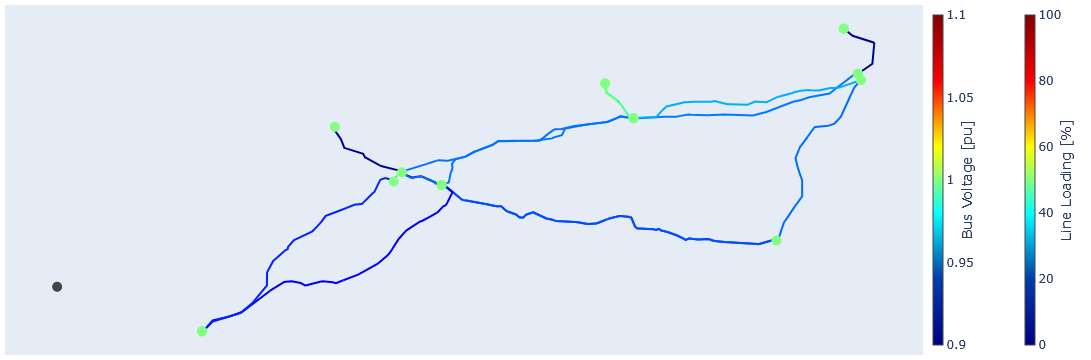

ac_pf converged successfully.


In [21]:
# **Step 1: Perform AC power flow analysis**
handle_pf_results("ac_pf", net, time_series_short, processed_regions, pp)
converged = False

#### 7.1.3 DC optimal power flow calculation with fallback mechanisms

AC power flow did not converge!
Trying DC OPF...
Error in dc_opf: Optimal Power Flow did not converge!
            time_step  total_load  total_generation  max_line_loading  \
0 2015-01-01 00:00:00     1045.47           1045.47         15.774209   
1 2015-01-01 01:00:00     1045.47           1045.47         15.774209   
2 2015-01-01 02:00:00     1004.79           1004.79         15.015744   
3 2015-01-01 03:00:00      983.79            983.79         14.624206   
4 2015-01-01 04:00:00      998.67            998.67         14.901638   
5 2015-01-01 05:00:00     1045.17           1045.17         15.768615   
6 2015-01-01 06:00:00     1085.06           1085.06         16.512351   
7 2015-01-01 07:00:00     1142.36           1142.36         17.580690   
8 2015-01-01 08:00:00     1206.03           1206.03         18.767796   
9 2015-01-01 09:00:00     1257.98           1257.98         19.736387   

   max_loading_index  
0               5789  
1               5789  
2               5789  
3

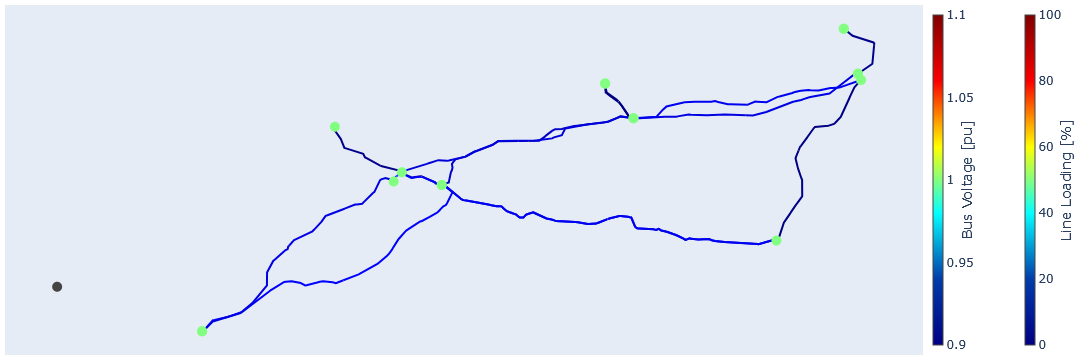

dc_opf converged successfully.
DC OPF converged setting conventional generators to minimal production


In [22]:
# Run DC optimal power flow    
if not converged:
    converged = False
    print("AC power flow did not converge!")
    print("Trying DC OPF...")

    # **Step 2: First DC OPF attempt**
    converged = handle_pf_results(
        "dc_opf", net, time_series_short, processed_regions, pp
    )
    if converged:
        print("Pf results on first try")
    else:
        # Modify generator parameters for another attempt
        net.gen.loc[
            (net.gen["controllable"]) & (~net.gen["type"].isin(["solar", "wind"])),
            "max_p_mw",
        ] = net.gen.loc[
            (net.gen["controllable"]) & (~net.gen["type"].isin(["solar", "wind"])),
            "p_mw",
        ]
        net.gen.loc[
            (net.gen["controllable"]) & (~net.gen["type"].isin(["solar", "wind"])),
            "min_p_mw",
        ] = 0

        # **Step 3: Second DC OPF attempt**
        converged = handle_pf_results(
            "dc_opf", net, time_series_short, processed_regions, pp
        )
        if converged:
            print(
                "DC OPF converged setting conventional generators to minimal production"
            )
        else:
            # Set all controllable generators to minimum production
            net.gen.loc[net.gen["controllable"], "max_p_mw"] = net.gen.loc[
                net.gen["controllable"], "p_mw"
            ]
            net.gen.loc[net.gen["controllable"], "min_p_mw"] = 0

            # **Step 4: Third DC OPF attempt (adjust loads)**
            converged = handle_pf_results(
                "dc_opf", net, time_series_short, processed_regions, pp, True
            )
            if converged:
                print("DC OPF converged setting all generators to minimal production")
            else:
                net.load["min_p_mw"] = net.load["p_mw"] * 0.1  # Allow load curtailment
                net.load["max_p_mw"] = net.load["p_mw"] * 1  # Keep max load unchanged
                net.load["controllable"] = True  # Enable load control

                # **Step 5: Final attempt before failure**
                converged = handle_pf_results(
                    "dc_opf", net, time_series_short, processed_regions, pp, True
                )
                if converged:
                    print("DC OPF converged setting variable loads")
                else:
                    print("DC OPF did not converge!")
                    simple_plotly(net)  # Generate diagnostic visualization
                    diagnose = pp.diagnostic(net)  # Run diagnostics
                    print("Diagnostic result:", diagnose)

#### 7.1.4 Calculating PF with scaling factor

In [23]:

def calculate_scaling_factor(net):
    total_gen_power = net.gen.loc[net.gen.in_service, "p_mw"].sum()
    total_load_power = net.load.loc[net.load.in_service, "p_mw"].sum()
    if total_gen_power > 0:
        scaling_factor = total_load_power / total_gen_power
    else:
        scaling_factor = 1
    print(f"Total generator power: {total_gen_power:.2f} MW")
    print(f"Total load power: {total_load_power:.2f} MW")
    print(f"Scaling factor: {scaling_factor:.3f}")

    return scaling_factor


if not converged:
    try:
        # Calculate scaling factor
        scaling_factor = calculate_scaling_factor(net)
        net.gen["scaling"] = scaling_factor

        # Ensure the function call includes required arguments
        pf_results = time_series_pf_results(
            "ac_pf", time_series_short, net, processed_regions, pp, True
        )

        # Check if all values in pf_results are NaN
        if pf_results.isna().all().all():
            print("All values in pf_results are NaN, skipping plot.")
        else:
            print(pf_results)
            pf_res_plotly(net)

    except KeyError as e:
        print(f"KeyError encountered: {e}")
        print("AC power flow did not converge due to a missing key!")

    except ValueError as e:
        print(f"ValueError encountered: {e}")
        print("AC power flow did not converge due to invalid values!")

    except Exception as e:  # Catch-all for unexpected errors
        print(f"Unexpected error: {e}")
        print("AC power flow also did not converge with scaling!")

### 7.2 Separate Results 

In [24]:
# Change False to True for Separate Results - Data will be exported as excel files
separate_results = False

def run_pf_results(mode, time_series_short, processed_regions, net, pp):
    """Runs the power flow analysis and handles errors properly."""
    try:
        time_series_pf_results_separate_exports(
            mode, time_series_short, processed_regions, net, pp
        )
        print(f"{mode} power flow analysis completed successfully.")
    except KeyError as e:
        print(f"KeyError encountered in {mode}: {e}")
    except ValueError as e:
        print(f"ValueError encountered in {mode}: {e}")
    except Exception as e:
        print(f"Unexpected error in {mode}: {e}")
        print(f"{mode} power flow did not converge!")

if separate_results:
    # **Execute all power flow analyses**
    for mode in ["ac_pf", "dc_opf", "ac_opf"]:
        run_pf_results(mode, time_series_short, processed_regions, net, pp)

## 8 Plotting

### 8.1 Plotting Connections Between Buses and Loads / Generation 

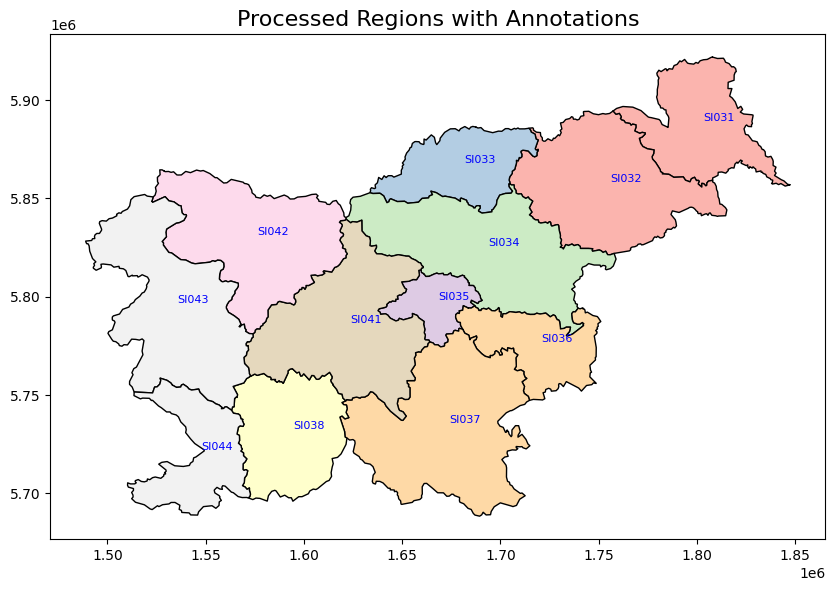

In [25]:
#Plotting Processed NUTS Regions:
plot_regions(processed_regions)

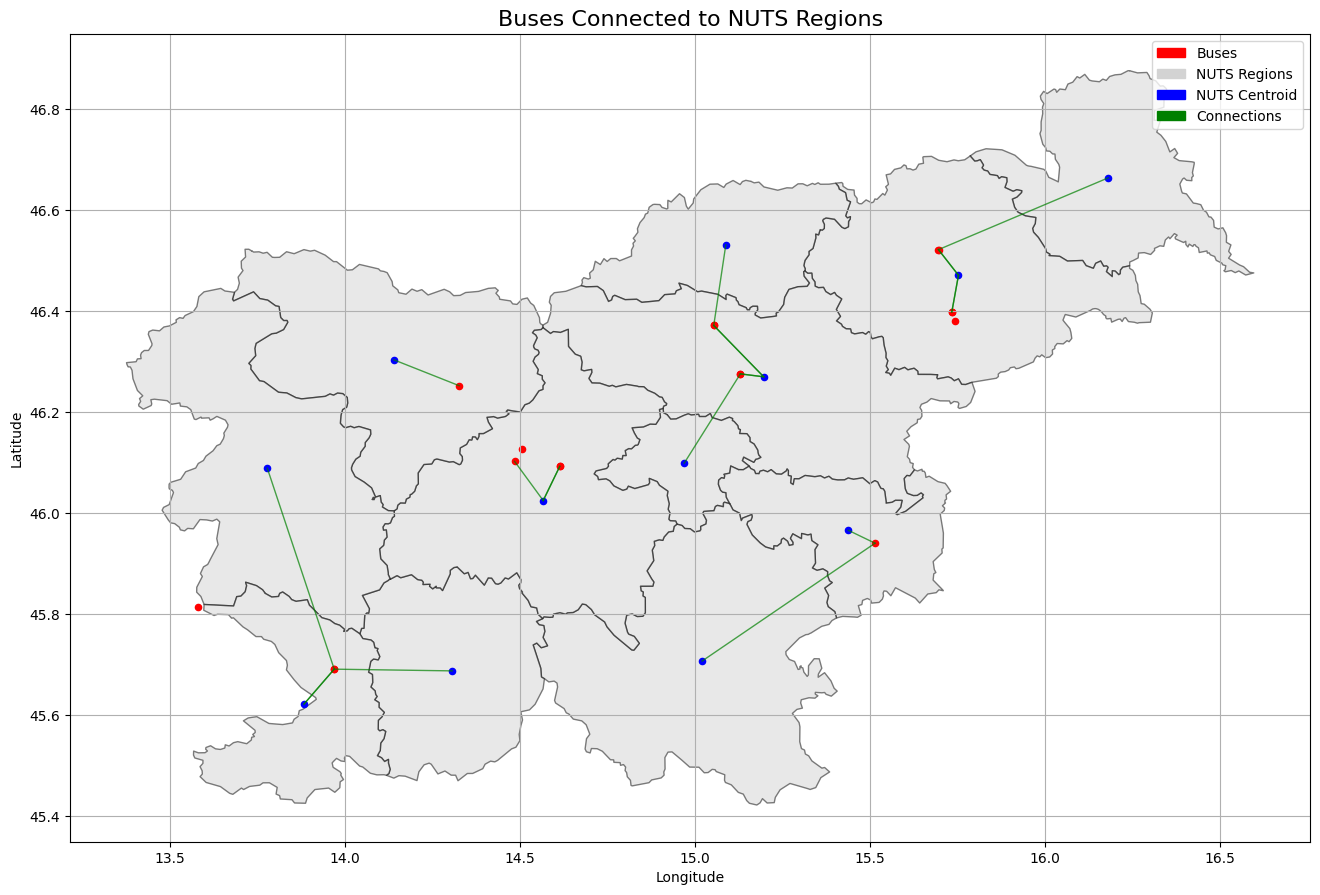

In [26]:
# Plotting Connections Between NUTS Centroids and Buses: 
plot_bus_nuts_connections(processed_regions=processed_regions, bus_geo=net.bus_geodata, net=net) 

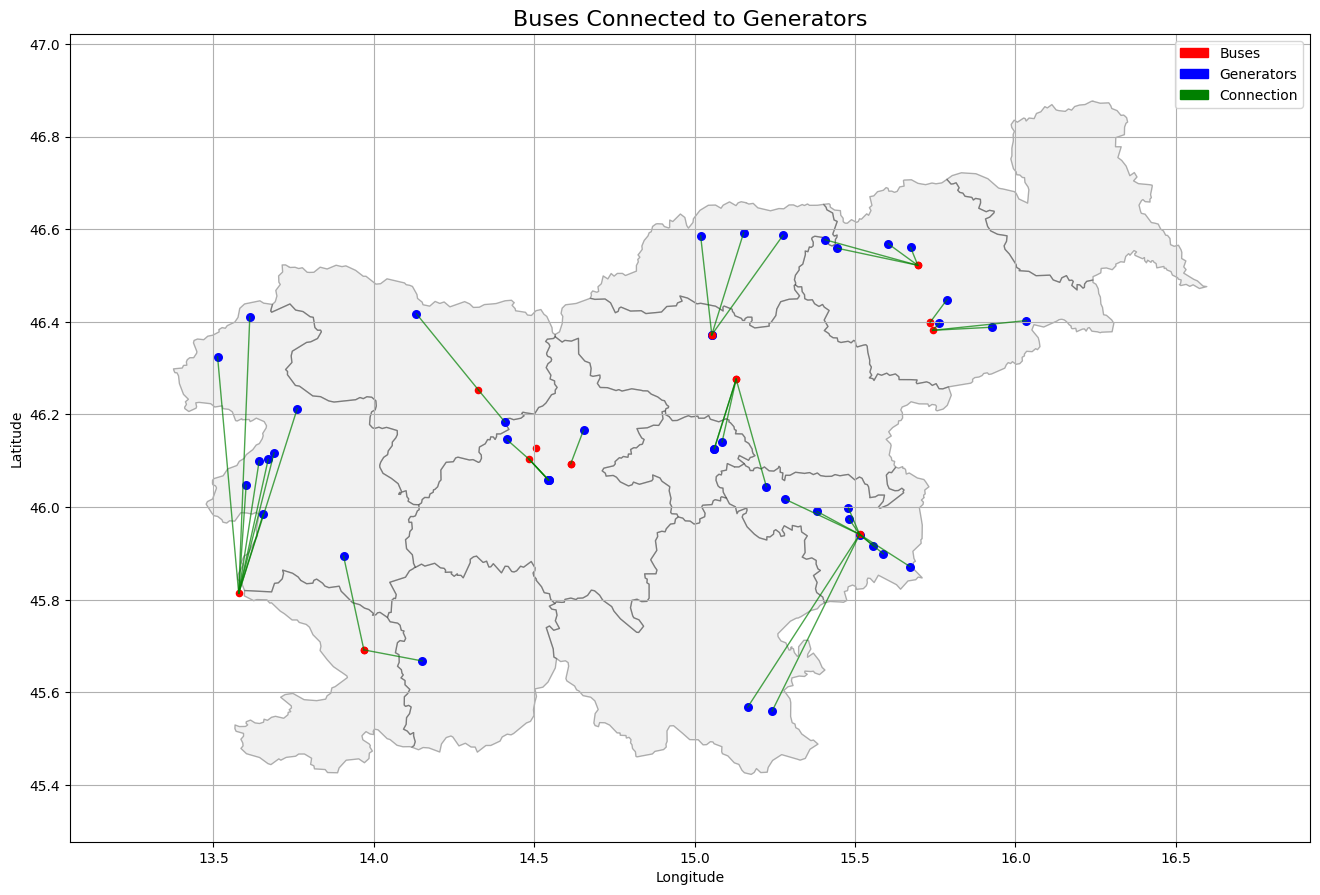

In [27]:
#Plotting Connections Between Generators and Buses: 
plot_bus_gen_connections(network=net, bus_geo=net.bus_geodata, nuts_regions=processed_regions, plants=plants)

### 8.2 Plotting Results - Generation and Consumption

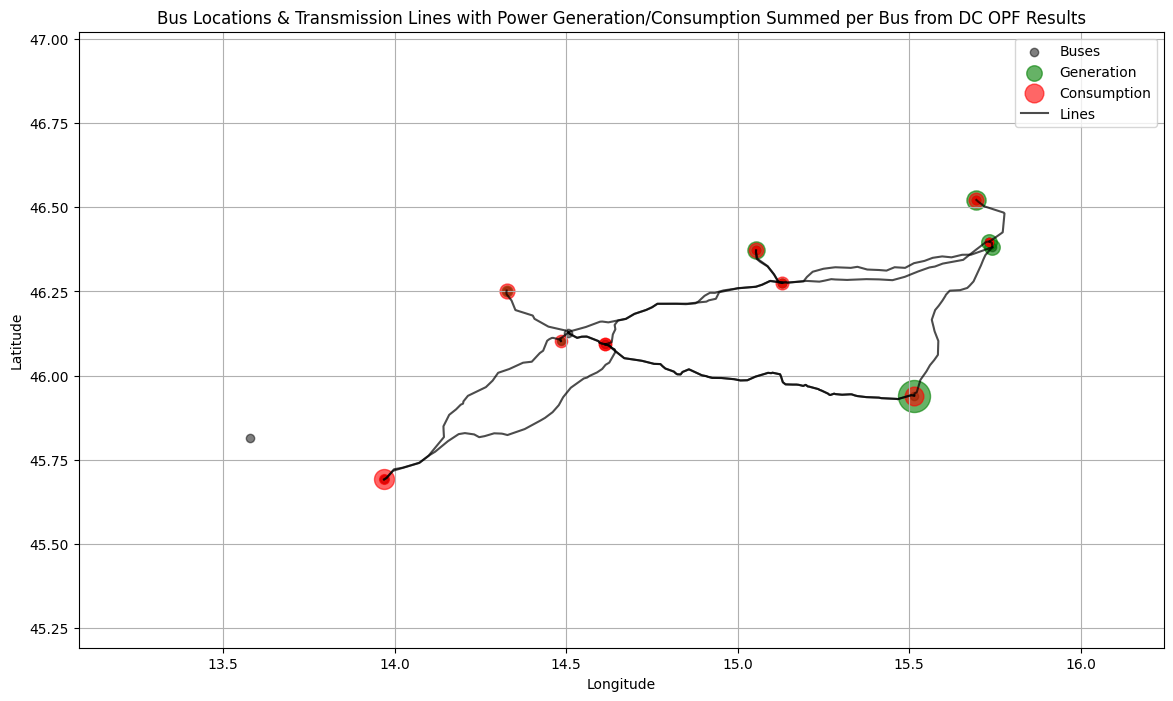

In [28]:
#Capacities from DC OPF results - combined:
plot_power_flow_with_lines(net, res=True, sum_p_mw=True)

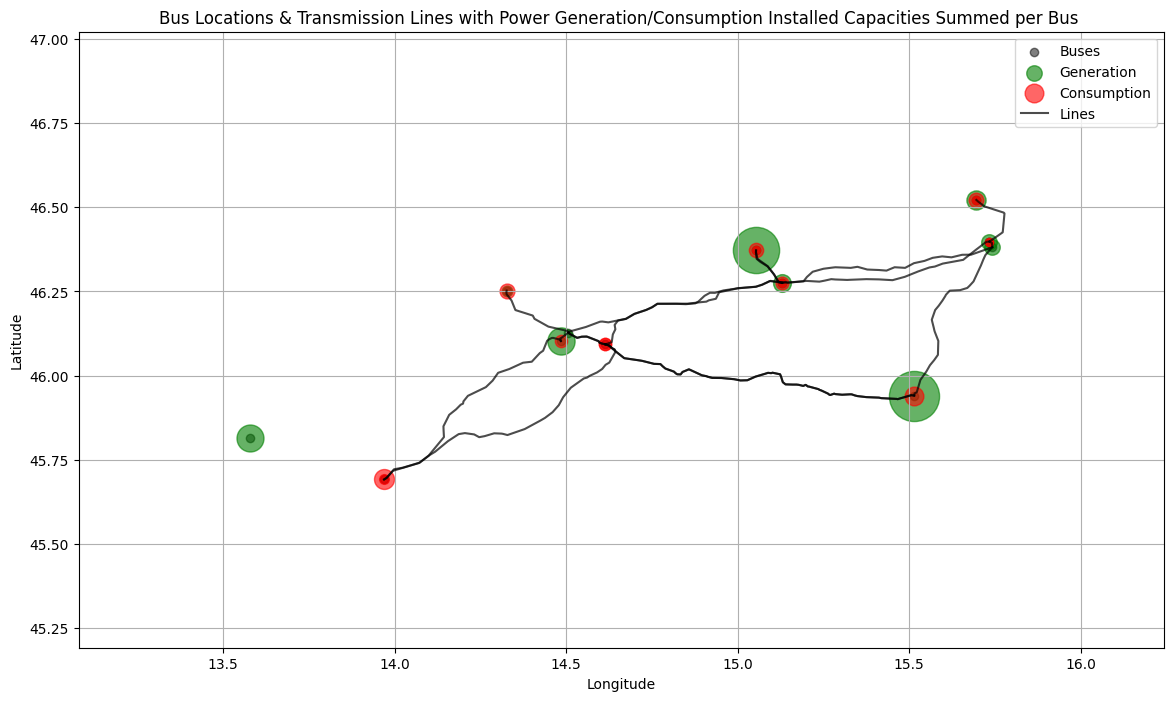

In [29]:
# Installed capacities per bus - combined
plot_power_flow_with_lines(net, res=False, sum_p_mw=True)

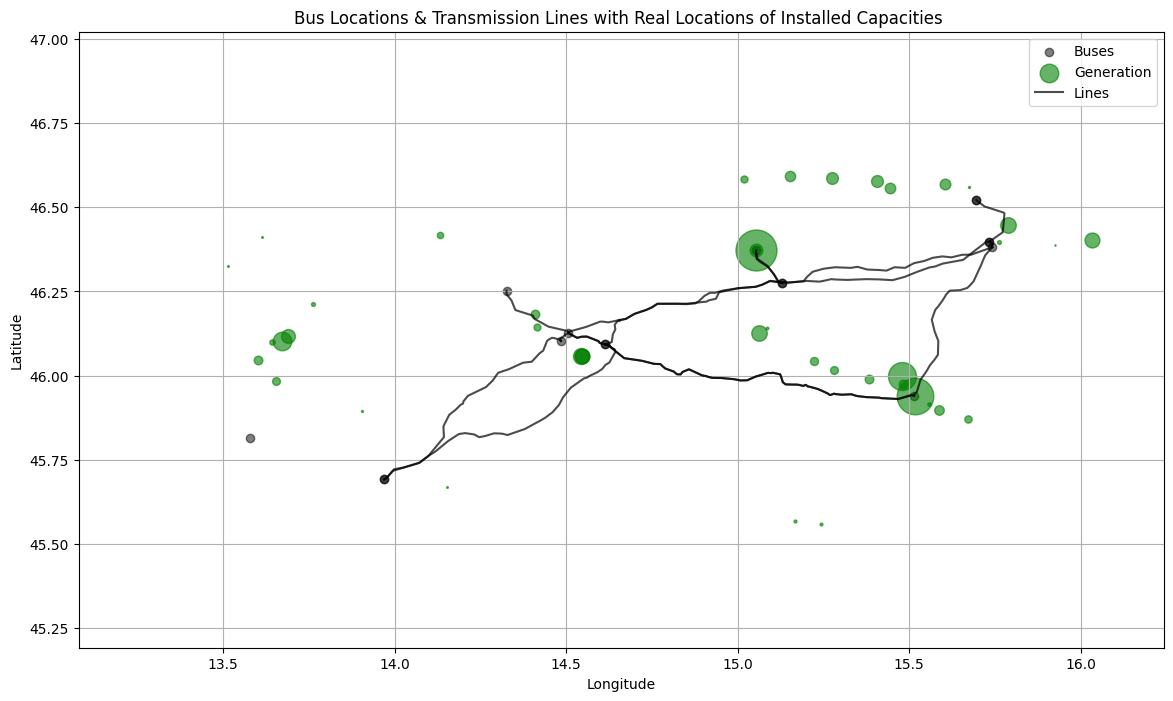

In [30]:
# Installed capacities - real locations
plot_power_flow_with_lines(net, res=False, plants=plants)